In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Import Library**

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.image as mpimg

# **Konfigurasi Model Pre-Train**

In [ ]:
# Folder ini akan dipecah menjadi 80% Train, 20% Validation
PATH_SOURCE = '/content/drive/MyDrive/Machine Learning/Dataset Sampah/training'

# Folder ini akan menjadi Data Test
PATH_TEST_FINAL = '/content/drive/MyDrive/Machine Learning/Dataset Sampah/validation'

# Konfigurasi Gambar
UKURAN_GAMBAR = (224, 224)
BATCH_SIZE = 32

# **Data Generator**

In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)

print("--- Menyiapkan Data Generator ---")

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

# 1. TRAINING GENERATOR (Subset: Training)
train_generator = train_datagen.flow_from_directory(
    PATH_SOURCE,
    target_size=UKURAN_GAMBAR,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',  # Ambil bagian 80%
    shuffle=True
)

# 2. VALIDATION GENERATOR (Subset: Validation)
# Digunakan oleh ModelCheckpoint & EarlyStopping
validation_generator = train_datagen.flow_from_directory(
    PATH_SOURCE,
    target_size=UKURAN_GAMBAR,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation', # Ambil bagian 20%
    shuffle=False
)

# 3. TEST GENERATOR (Data Terpisah)
# Digunakan HANYA untuk evaluasi akhir & Confusion Matrix
test_generator = test_datagen.flow_from_directory(
    PATH_TEST_FINAL,
    target_size=UKURAN_GAMBAR,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Ambil label kelas dan jumlahnya
class_indices = train_generator.class_indices
LABEL_KELAS = list(class_indices.keys())
JUMLAH_KELAS = len(LABEL_KELAS)
print(f"\nKelas ditemukan: {class_indices}")

--- Menyiapkan Data Generator ---
Found 1841 images belonging to 3 classes.
Found 459 images belonging to 3 classes.
Found 813 images belonging to 3 classes.

Kelas ditemukan: {'Kaca': 0, 'Kardus': 1, 'Plastik': 2}


# **Arsitektur Model**

In [ ]:
base_model = MobileNetV2(weights='imagenet', include_top=False,
                         input_shape=(UKURAN_GAMBAR[0], UKURAN_GAMBAR[1], 3))

base_model.trainable = False  # Bekukan base model

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(JUMLAH_KELAS, activation='softmax')
])

# **Kompilasi Model**

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,586,691 (9.87 MB)

 Trainable params: 328,707 (1.25 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

# **Training Model**


Model terbaik akan disimpan ke: /content/drive/MyDrive/Machine Learning/Models/mobilenet_sampah_best_3split.h5

Mulai melatih model...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 24s/step - accuracy: 0.6751 - loss: 0.8072 
Epoch 1: val_accuracy improved from -inf to 0.87500, saving model to /content/drive/MyDrive/Machine Learning/Models/mobilenet_sampah_best_3split.h5


57/57 ━━━━━━━━━━━━━━━━━━━━ 1744s 30s/step - accuracy: 0.6769 - loss: 0.8030 - val_accuracy: 0.8750 - val_loss: 0.3380
Epoch 2/30
 1/57 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.8438 - loss: 0.3769

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy did not improve from 0.87500
57/57 ━━━━━━━━━━━━━━━━━━━━ 15s 263ms/step - accuracy: 0.8438 - loss: 0.3769 - val_accuracy: 0.8705 - val_loss: 0.3640
Epoch 3/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step - accuracy: 0.8887 - loss: 0.2809
Epoch 3: val_accuracy did not improve from 0.87500
57/57 ━━━━━━━━━━━━━━━━━━━━ 35s 604ms/step - accuracy: 0.8885 - loss: 0.2813 - val_accuracy: 0.8728 - val_loss: 0.2931
Epoch 4/30
 1/57 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.9375 - loss: 0.2425
Epoch 4: val_accuracy improved from 0.87500 to 0.88170, saving model to /content/drive/MyDrive/Machine Learning/Models/mobilenet_sampah_best_3split.h5


57/57 ━━━━━━━━━━━━━━━━━━━━ 9s 162ms/step - accuracy: 0.9375 - loss: 0.2425 - val_accuracy: 0.8817 - val_loss: 0.3054
Epoch 5/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step - accuracy: 0.8828 - loss: 0.2886
Epoch 5: val_accuracy improved from 0.88170 to 0.88839, saving model to /content/drive/MyDrive/Machine Learning/Models/mobilenet_sampah_best_3split.h5


57/57 ━━━━━━━━━━━━━━━━━━━━ 36s 628ms/step - accuracy: 0.8829 - loss: 0.2885 - val_accuracy: 0.8884 - val_loss: 0.3062
Epoch 6/30
 1/57 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.8125 - loss: 0.4347
Epoch 6: val_accuracy did not improve from 0.88839
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 115ms/step - accuracy: 0.8125 - loss: 0.4347 - val_accuracy: 0.8795 - val_loss: 0.3104
Epoch 7/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step - accuracy: 0.9198 - loss: 0.2310
Epoch 7: val_accuracy did not improve from 0.88839
57/57 ━━━━━━━━━━━━━━━━━━━━ 35s 621ms/step - accuracy: 0.9196 - loss: 0.2311 - val_accuracy: 0.8817 - val_loss: 0.3121
Epoch 8/30
 1/57 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.8750 - loss: 0.2857
Epoch 8: val_accuracy did not improve from 0.88839
57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 117ms/step - accuracy: 0.8750 - loss: 0.2857 - val_accuracy: 0.8839 - val_loss: 0.3079
Epoch 8: early stopping
Restoring model weights from the end of the best epoch: 3.


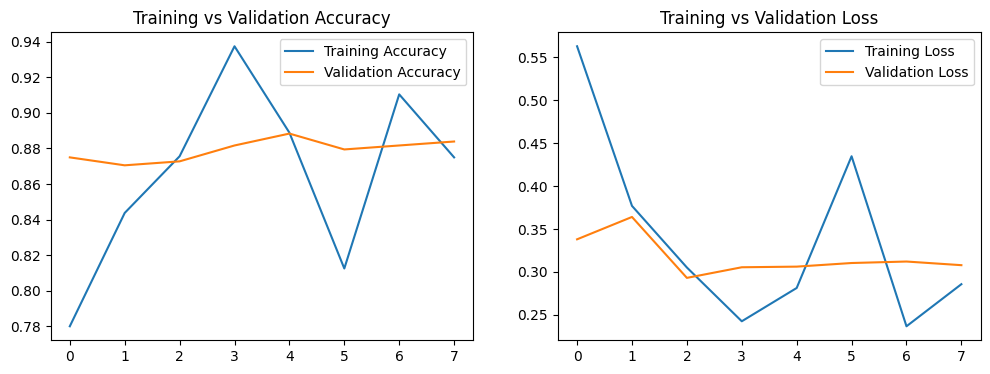

In [ ]:
drive_model_folder = '/content/drive/MyDrive/Machine Learning/Models'
if not os.path.exists(drive_model_folder):
    os.makedirs(drive_model_folder)

filepath = os.path.join(drive_model_folder, 'mobilenet_sampah_best_3split.h5')
print(f"\nModel terbaik akan disimpan ke: {filepath}")

# Callbacks
early_stop = EarlyStopping(
    monitor='val_loss',       # Memantau performa di Validation Generator
    patience=5,
    restore_best_weights=True,
    verbose=1
)

checkpoint = ModelCheckpoint(
    filepath,
    monitor='val_accuracy',   # Menyimpan jika akurasi di Validation naik
    save_best_only=True,
    verbose=1
)

print("\nMulai melatih model...")
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=30,
    validation_data=validation_generator,  # Validasi saat training
    validation_steps=validation_generator.samples // BATCH_SIZE,
    callbacks=[early_stop, checkpoint]
)

# Plotting Training History
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()

# **Evaluasi Model**


   EVALUASI PADA DATA TEST (UNSEEN DATA)


26/26 ━━━━━━━━━━━━━━━━━━━━ 12s 238ms/step - accuracy: 0.9639 - loss: 0.1051

Akurasi Final pada Test Set: 89.42%
Menghasilkan prediksi detail...
26/26 ━━━━━━━━━━━━━━━━━━━━ 12s 295ms/step


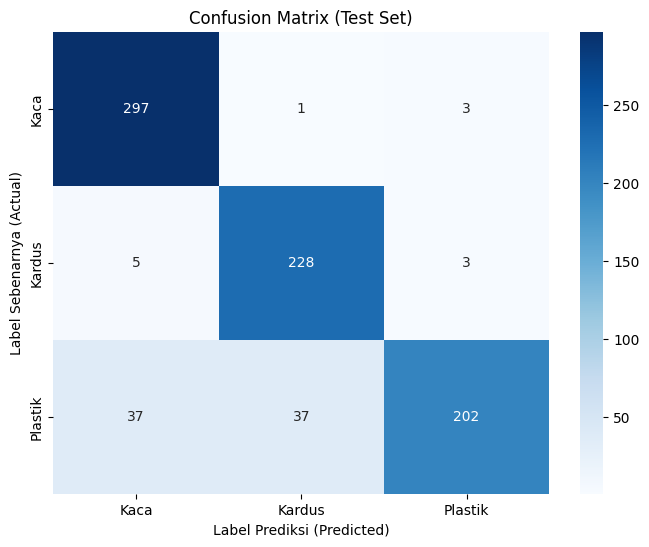


--- Classification Report (Test Set) ---
              precision    recall  f1-score   support

        Kaca       0.88      0.99      0.93       301
      Kardus       0.86      0.97      0.91       236
     Plastik       0.97      0.73      0.83       276

    accuracy                           0.89       813
   macro avg       0.90      0.89      0.89       813
weighted avg       0.90      0.89      0.89       813


Total kesalahan pada Test Set: 86 dari 813 gambar.


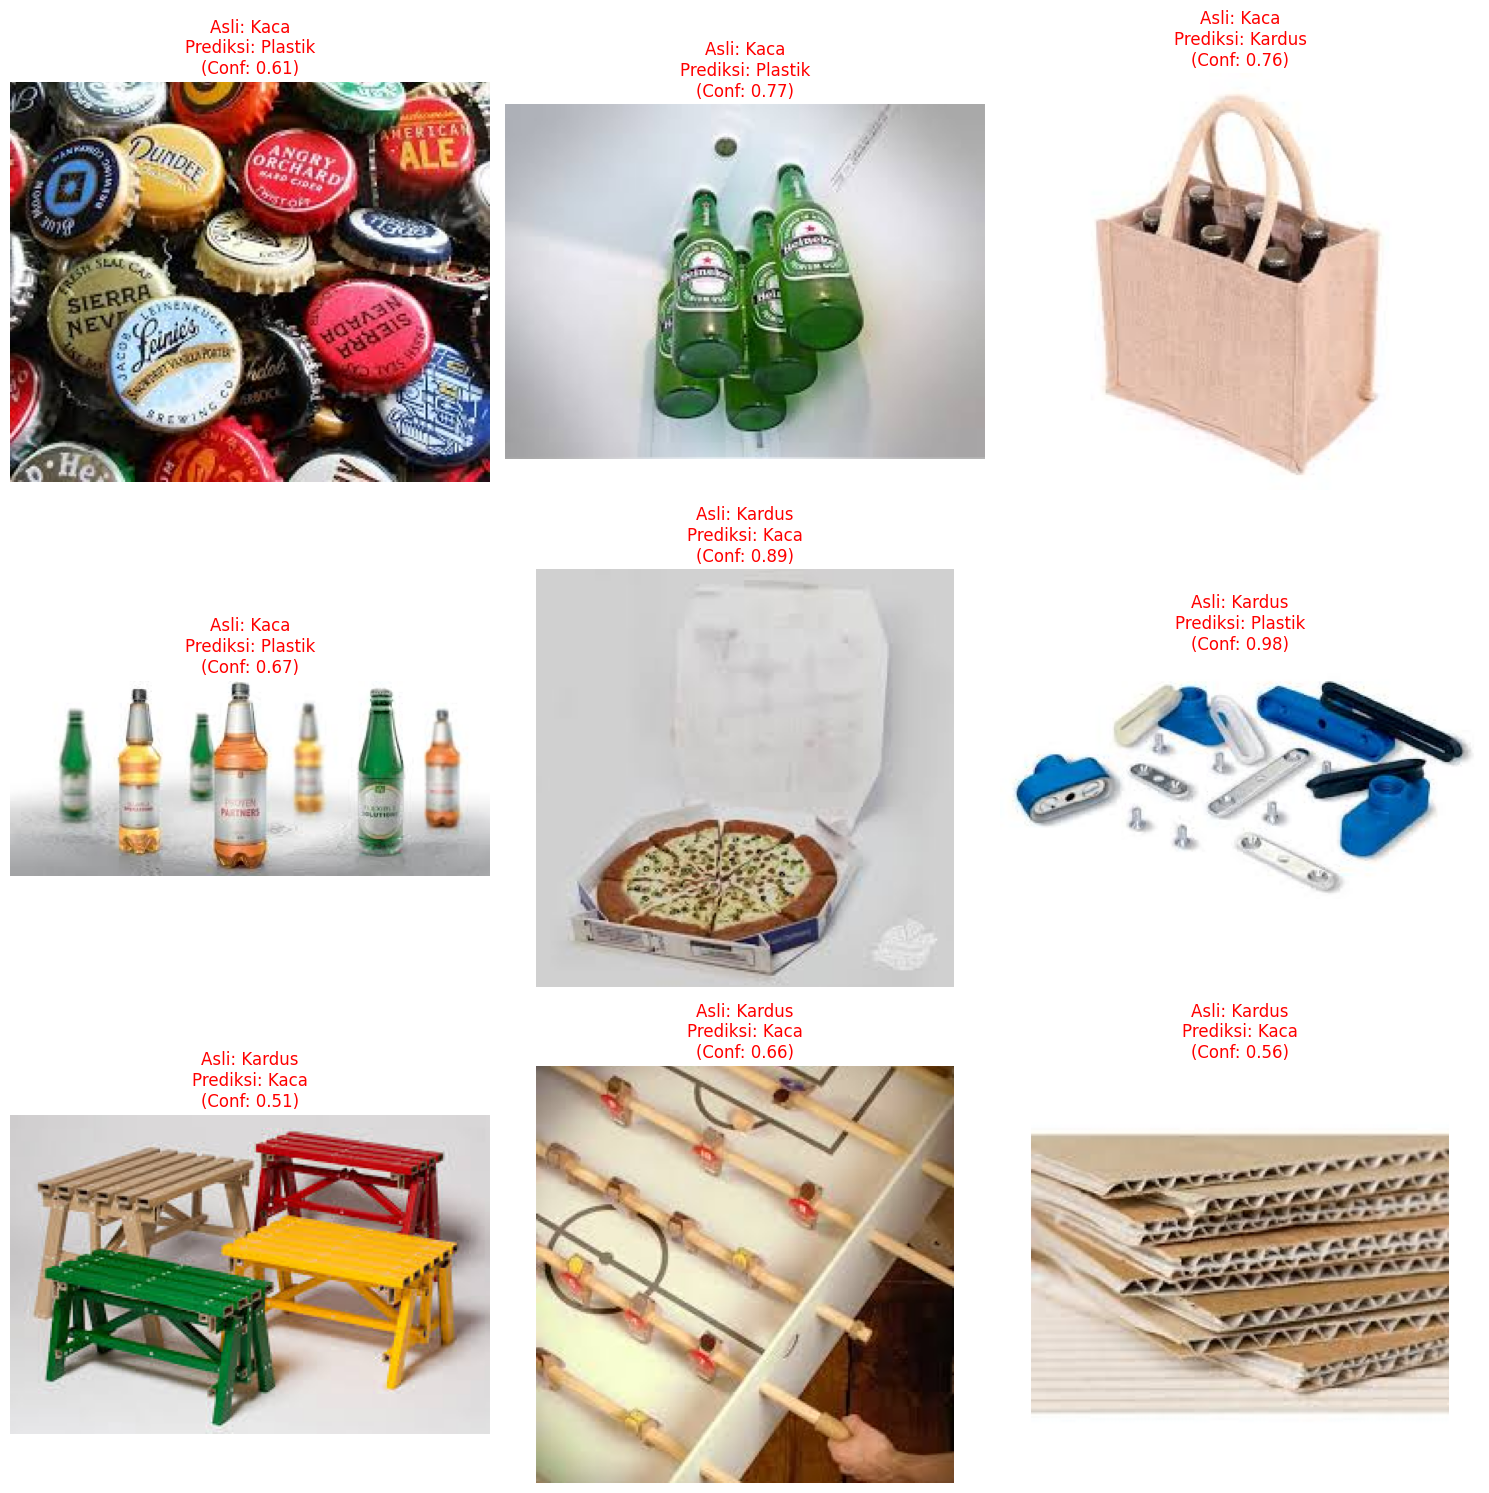

In [ ]:
print("\n" + "="*40)
print("   EVALUASI PADA DATA TEST (UNSEEN DATA)")
print("="*40)

# Pastikan menggunakan model terbaik yang tersimpan
best_model = load_model(filepath)

# Evaluasi Score
test_loss, test_accuracy = best_model.evaluate(test_generator)
print(f"\nAkurasi Final pada Test Set: {test_accuracy*100:.2f}%")
# Reset generator agar urutan prediksi sesuai
test_generator.reset()

print("Menghasilkan prediksi detail...")
Y_pred = best_model.predict(test_generator)
y_pred_indices = np.argmax(Y_pred, axis=1)
y_true_indices = test_generator.classes
filenames = test_generator.filenames

# Confusion Matrix
cm = confusion_matrix(y_true_indices, y_pred_indices)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=LABEL_KELAS, yticklabels=LABEL_KELAS)
plt.ylabel('Label Sebenarnya (Actual)')
plt.xlabel('Label Prediksi (Predicted)')
plt.title('Confusion Matrix (Test Set)')
plt.show()

# Classification Report
print("\n--- Classification Report (Test Set) ---")
print(classification_report(y_true_indices, y_pred_indices, target_names=LABEL_KELAS))

# Galeri Kesalahan (Wrong Predictions)
errors = np.where(y_pred_indices != y_true_indices)[0]
print(f"\nTotal kesalahan pada Test Set: {len(errors)} dari {len(y_true_indices)} gambar.")

if len(errors) > 0:
    max_display = 9
    display_indices = errors[:max_display]
    num_rows = (len(display_indices) // 3) + 1

    plt.figure(figsize=(15, 5 * num_rows))

    for i, error_idx in enumerate(display_indices):
        # Ambil path gambar error dari Test Set
        file_path = os.path.join(PATH_TEST_FINAL, filenames[error_idx])

        img = mpimg.imread(file_path)
        true_label = LABEL_KELAS[y_true_indices[error_idx]]
        pred_label = LABEL_KELAS[y_pred_indices[error_idx]]
        confidence = Y_pred[error_idx][y_pred_indices[error_idx]]

        plt.subplot(num_rows, 3, i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Asli: {true_label}\nPrediksi: {pred_label}\n(Conf: {confidence:.2f})", color='red')

    plt.tight_layout()
    plt.show()